<div style="text-align: center; padding-bottom: 20px;">
  <h1 style="color: #95a5a6; font-family: 'Arial', sans-serif; padding: 20px; border-bottom: 2px solid #95a5a6;">IMAGE PROCESSING AND COMPUTER VISION</h1>
  <h2 style="color: #95a5a6; font-family: 'Arial', sans-serif; padding: 30px; border-bottom: 2px solid #95a5a6;">LAB 03</h2>
</div>

**Importing Libraries**

In [1]:
!pip install gdown
!pip install rarfile

In [2]:
import os
import random
import gdown
import rarfile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import local_binary_pattern, hog
from skimage import io, color
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import cv2

**Constants and Utility Functions**

In [3]:
# Define constants
URL = 'https://drive.google.com/uc?id=1viLs_Tyu5gTtZvX0fumX4LW4tpIFCbvr'
OUTPUT_FILE = 'ORL_20_subjects.rar'
DATASET_PATH = 'dataset'
NUM_IMAGES_TO_PLOT = 5

def download_and_extract(url, output_file, extract_to):
    """Download and extract a RAR file from Google Drive."""
    gdown.download(url, output_file, quiet=False)
    with rarfile.RarFile(output_file) as rf:
        rf.extractall(extract_to)
    os.remove(output_file)

def load_dataset(dataset_path):
    """Load images and labels from the dataset."""
    data = []
    for class_folder in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_folder)
        for image_file in os.listdir(class_path):
            image_path = os.path.join(class_path, image_file)
            image_label = int(image_file.split('_')[1].split('.')[0])
            data.append((image_path, image_label))
    return data

def plot_images(images, num_images_to_plot):
    """Plot a specified number of images with their labels."""
    images_to_plot = images[:num_images_to_plot]
    fig = plt.figure(figsize=(10, 10))
    columns = num_images_to_plot
    rows = 1
    for i, (image_path, image_label) in enumerate(images_to_plot):
        img = mpimg.imread(image_path)
        ax = fig.add_subplot(rows, columns, i+1)
        ax.imshow(img, cmap='gray')
        ax.title.set_text(f'Label: {image_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

**Data Preparation Functions**

In [4]:
def split_data(data, train_ratio=0.8):
    """Shuffle and split data into training and testing sets."""
    random.shuffle(data)
    split_index = int(train_ratio * len(data))
    return data[:split_index], data[split_index:]

def extract_features(data):
    """Extract LBP and HOG features from the dataset."""
    lbp_features = []
    hog_features = []
    for image_path, _ in data:
        img = io.imread(image_path, as_gray=True)
        lbp = local_binary_pattern(img, 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), range=(0, 9))
        lbp_features.append(lbp_hist)
        img_color = color.gray2rgb(img)
        hog_feat, _ = hog(img_color, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), visualize=True, multichannel=True)
        hog_features.append(hog_feat)
    return np.array(lbp_features), np.array(hog_features)

**Model Training and Evaluation Functions**

In [5]:
def train_and_evaluate_model(train_features, train_labels, test_features, test_labels, model, feature_name):
    """Train and evaluate a model with specified features."""
    model.fit(train_features, train_labels)
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"{feature_name} + {model.__class__.__name__} Accuracy:", accuracy)
    return predictions, accuracy

def plot_confusion_matrix(true_labels, predictions, title):
    """Plot confusion matrix."""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

**Download and Extract Dataset**

In [6]:
# Download and extract the dataset
download_and_extract(URL, OUTPUT_FILE, DATASET_PATH)

Downloading...
From: https://drive.google.com/uc?id=1viLs_Tyu5gTtZvX0fumX4LW4tpIFCbvr
To: /content/ORL_20_subjects.rar
100%|██████████| 574k/574k [00:00<00:00, 7.93MB/s]


**Load Dataset and Plot Sample Images**

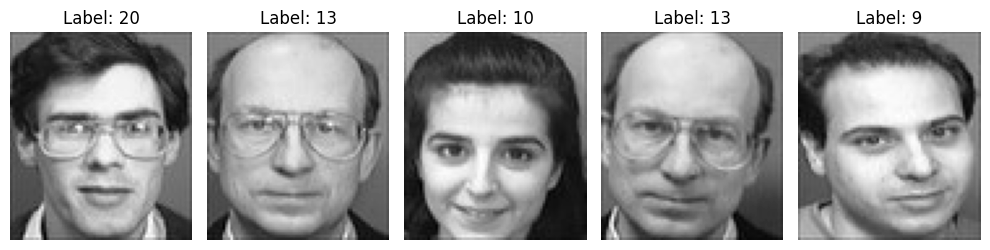

In [7]:
# Load the dataset
data = load_dataset(DATASET_PATH)

# Plot a few images from the dataset
plot_images(data, NUM_IMAGES_TO_PLOT)

**Split Data and Extract Features**

In [8]:
# Split the data into training and testing sets
training_data, testing_data = split_data(data)

# Extract features from the training and testing sets
train_lbp_features, train_hog_features = extract_features(training_data)
test_lbp_features, test_hog_features = extract_features(testing_data)

<ipython-input-4-42b72b6a9809>:17: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feat, _ = hog(img_color, orientations=9, pixels_per_cell=(8, 8),


**Train and Evaluate Models**

In [9]:
# Train and evaluate models using LBP and HOG features
train_labels = [label for _, label in training_data]
test_labels = [label for _, label in testing_data]

knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC()

# LBP Features
knn_lbp_predictions, lbp_knn_accuracy = train_and_evaluate_model(train_lbp_features, train_labels, test_lbp_features, test_labels, knn, "LBP")
svm_lbp_predictions, lbp_svm_accuracy = train_and_evaluate_model(train_lbp_features, train_labels, test_lbp_features, test_labels, svm, "LBP")

# HOG Features
knn_hog_predictions, hog_knn_accuracy = train_and_evaluate_model(train_hog_features, train_labels, test_hog_features, test_labels, knn, "HOG")
svm_hog_predictions, hog_svm_accuracy = train_and_evaluate_model(train_hog_features, train_labels, test_hog_features, test_labels, svm, "HOG")

LBP + KNeighborsClassifier Accuracy: 0.3
LBP + SVC Accuracy: 0.075
HOG + KNeighborsClassifier Accuracy: 0.9
HOG + SVC Accuracy: 0.9


**Plot Confusion Matrices**

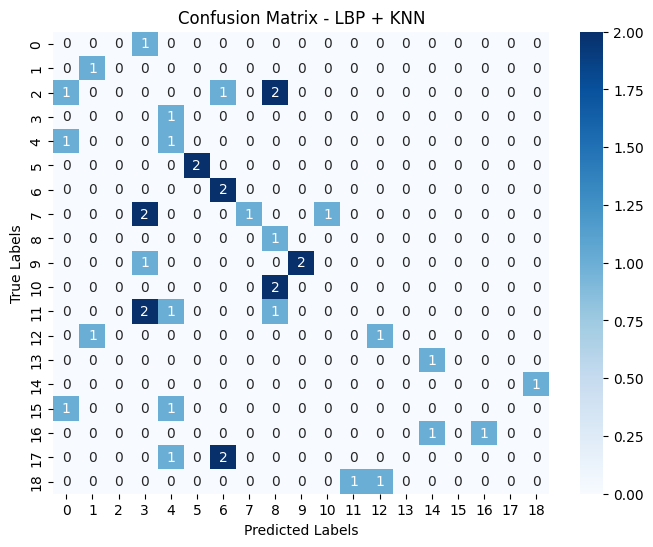

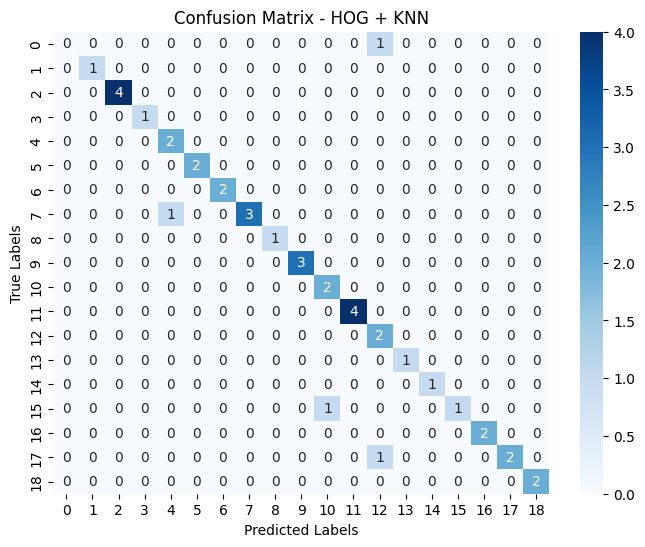

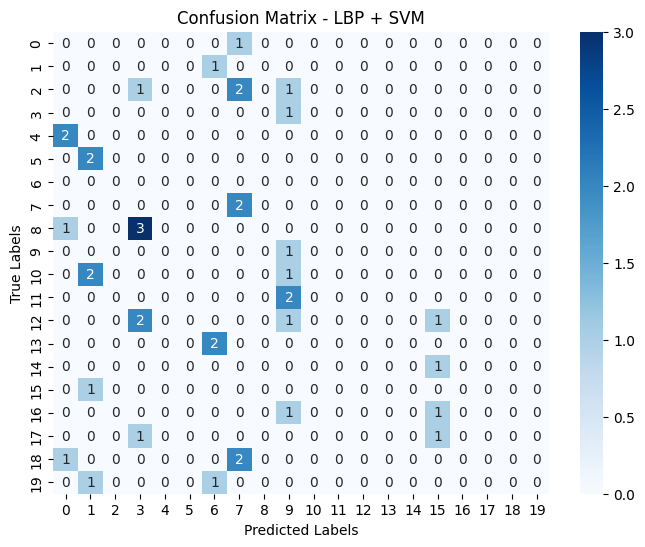

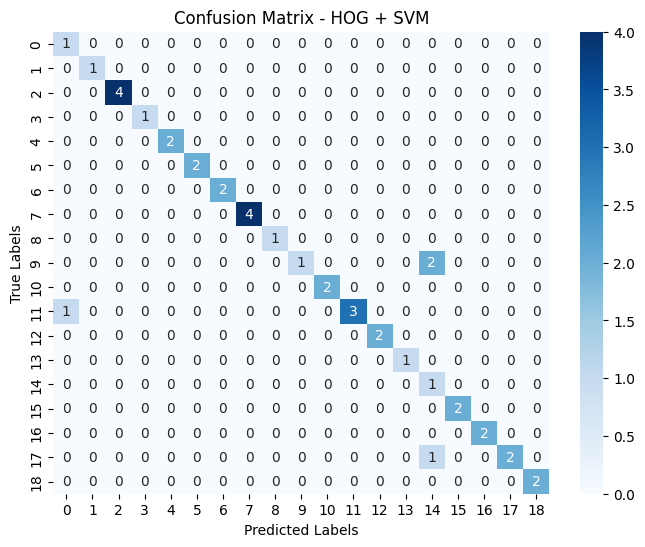

In [10]:
# Plot confusion matrices
plot_confusion_matrix(test_labels, knn_lbp_predictions, "Confusion Matrix - LBP + KNN")
plot_confusion_matrix(test_labels, knn_hog_predictions, "Confusion Matrix - HOG + KNN")
plot_confusion_matrix(test_labels, svm_lbp_predictions, "Confusion Matrix - LBP + SVM")
plot_confusion_matrix(test_labels, svm_hog_predictions, "Confusion Matrix - HOG + SVM")

**Example of SIFT Feature Extraction**

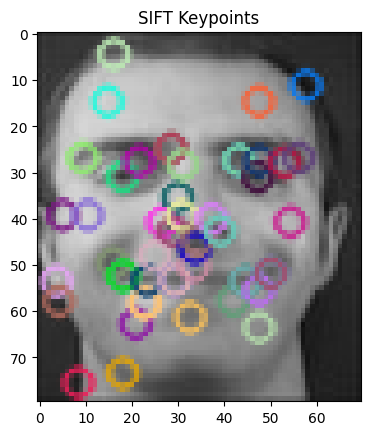

In [11]:
# Example of SIFT feature extraction
image_path = data[0][0]
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
sift = cv2.SIFT_create()
keypoints, descriptors = sift.detectAndCompute(gray_image, None)
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
plt.imshow(image_with_keypoints)
plt.title("SIFT Keypoints")
plt.show()

**============================================================================================================================================================================================================================**

**Constants and Utility Functions for New Dataset**

In [12]:
# Constants for the new dataset
FRUIT_URL = 'https://drive.google.com/uc?id=1ZtVTTxAHMavnYdeCUoqQyaZkNk_eF3IR'
FRUIT_OUTPUT_FILE = 'fruit_dataset.rar'
FRUIT_DATASET_PATH = 'fruit_dataset'
TRAIN_FOLDER = 'train'
TEST_FOLDER = 'test'

def extract_color_histogram(image_path, bins=(3, 3, 3)):
    """Extract color histogram by quantizing the RGB color space into given bins."""
    img = cv2.imread(image_path)
    hist = cv2.calcHist([img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def load_fruit_dataset(dataset_path):
    """Load images and labels from the dataset with separate train and test folders."""
    train_data, test_data = [], []
    for fruit in os.listdir(dataset_path):
        fruit_path = os.path.join(dataset_path, fruit)
        train_path = os.path.join(fruit_path, TRAIN_FOLDER)
        test_path = os.path.join(fruit_path, TEST_FOLDER)
        for image_file in os.listdir(train_path):
            image_path = os.path.join(train_path, image_file)
            train_data.append((image_path, fruit))
        for image_file in os.listdir(test_path):
            image_path = os.path.join(test_path, image_file)
            test_data.append((image_path, fruit))
    return train_data, test_data


**Download and Extract Fruit Dataset**

In [13]:
# Download and extract the fruit dataset
download_and_extract(FRUIT_URL, FRUIT_OUTPUT_FILE, FRUIT_DATASET_PATH)


Downloading...
From: https://drive.google.com/uc?id=1ZtVTTxAHMavnYdeCUoqQyaZkNk_eF3IR
To: /content/fruit_dataset.rar
100%|██████████| 4.33M/4.33M [00:00<00:00, 28.8MB/s]


**Load Fruit Dataset and Plot Sample Images**

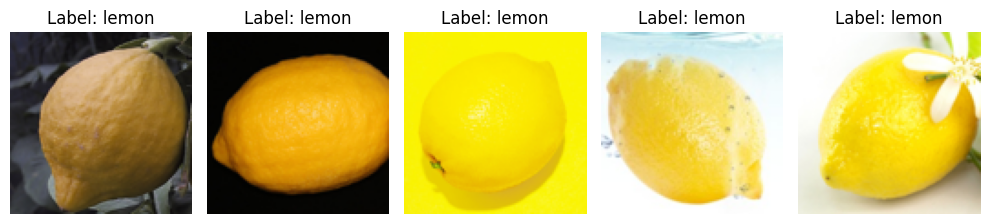

In [14]:
# Load the fruit dataset
fruit_train_data, fruit_test_data = load_fruit_dataset(FRUIT_DATASET_PATH)

# Plot a few images from the fruit dataset
plot_images(fruit_train_data, 5)


**Extract Color Histogram Features**

In [15]:
# Extract color histogram features from the training and testing sets
fruit_train_features = np.array([extract_color_histogram(path) for path, _ in fruit_train_data])
fruit_train_labels = [label for _, label in fruit_train_data]
fruit_test_features = np.array([extract_color_histogram(path) for path, _ in fruit_test_data])
fruit_test_labels = [label for _, label in fruit_test_data]


**Train and Evaluate Models on Fruit Dataset**

In [16]:
# Train and evaluate models using color histogram features from the fruit dataset
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC()

# Color Histogram Features for Fruit Dataset
knn_fruit_predictions, knn_fruit_accuracy = train_and_evaluate_model(
    fruit_train_features, fruit_train_labels, fruit_test_features, fruit_test_labels, knn, "Color Histogram (Fruit)")

svm_fruit_predictions, svm_fruit_accuracy = train_and_evaluate_model(
    fruit_train_features, fruit_train_labels, fruit_test_features, fruit_test_labels, svm, "Color Histogram (Fruit)")

Color Histogram (Fruit) + KNeighborsClassifier Accuracy: 0.94
Color Histogram (Fruit) + SVC Accuracy: 0.96


**Plot Confusion Matrices for Fruit Dataset**

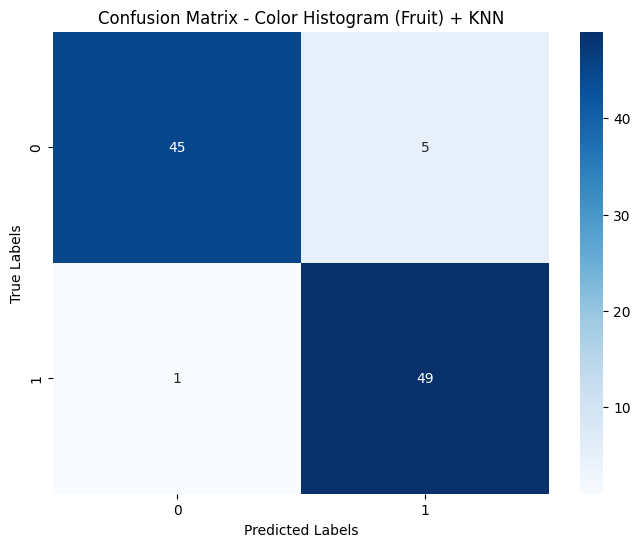

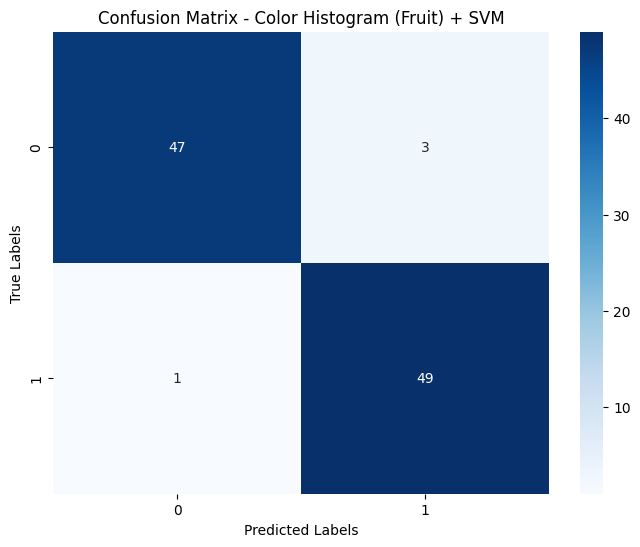

In [17]:
# Plot confusion matrices for fruit dataset
plot_confusion_matrix(fruit_test_labels, knn_fruit_predictions, "Confusion Matrix - Color Histogram (Fruit) + KNN")
plot_confusion_matrix(fruit_test_labels, svm_fruit_predictions, "Confusion Matrix - Color Histogram (Fruit) + SVM")
